<a href="https://colab.research.google.com/github/paddy-03/Voice-Recognition-of-a-Singer/blob/master/Voice_Recognition_(Resnet50V2)_.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Voice Recognition of a Singer using CNN**

In [0]:
import numpy as np
import matplotlib.pyplot as plt

In [2]:
from google.colab import drive
drive.mount('/content/drive') 

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [0]:
import os
os.chdir('./drive/My Drive')

In [0]:
baseDir = '/content/drive/My Drive/Specs/'
trainDir = baseDir + 'train'
testDir = baseDir + 'test'
valDir = baseDir + 'validation'

In [0]:
width = 225
height = 150
epochs = 20
batch_size = 5
num_classes = 8

In [0]:
import keras
from keras.applications import VGG16, ResNet50V2
from keras.preprocessing.image import ImageDataGenerator
from keras import layers
from keras import models
from keras.layers import Conv2D, MaxPool2D, Flatten,Dense, Dropout

### Using Resnet50V2 model 

In [9]:
conv_base = ResNet50V2(weights='imagenet',
include_top=False,
input_shape=(225, 150, 3))
conv_base.trainable = False  #freezing all layers of the resnet50 model













94674944/94668760 [==============================] - 3s 0us/step


In [10]:
conv_base.summary()

Model: "resnet50v2"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 225, 150, 3)  0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, 231, 156, 3)  0           input_1[0][0]                    
__________________________________________________________________________________________________
conv1_conv (Conv2D)             (None, 113, 75, 64)  9472        conv1_pad[0][0]                  
__________________________________________________________________________________________________
pool1_pad (ZeroPadding2D)       (None, 115, 77, 64)  0           conv1_conv[0][0]                 
_________________________________________________________________________________________

In [0]:
#dense layers
from keras import models
from keras import layers
from keras import optimizers

model = models.Sequential()
model.add(layers.Dense(512, activation='relu',input_dim=8*5*2048))
model.add(Dropout(0.2))
model.add(layers.Dense(8, activation='softmax'))

In [12]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 512)               50332160  
_________________________________________________________________
dense_2 (Dense)              (None, 512)               262656    
_________________________________________________________________
dropout_1 (Dropout)          (None, 512)               0         
_________________________________________________________________
dense_3 (Dense)              (None, 8)                 4104      
Total params: 50,598,920
Trainable params: 50,598,920
Non-trainable params: 0
_________________________________________________________________


### **Extracting features from the spectrograms**

In [0]:
#Extracting the features and labels as numpy arrays
#predict function of conv_base is used to get the features of the image
datagen = ImageDataGenerator(rescale=1./255)
batch_size = 5
def extract_features(directory, sample_count):
  features = np.zeros(shape=(sample_count, 8, 5, 2048))
  labels = np.zeros(shape=(sample_count,8))
  generator = datagen.flow_from_directory( directory,
  target_size=(225,150),
  batch_size=batch_size,
  shuffle = False,                               
  class_mode='categorical')
  print(generator.class_indices)
  i = 0
  for inputs_batch, labels_batch in generator:
    features_batch = conv_base.predict(inputs_batch)
    features[i * batch_size : (i + 1) * batch_size] = features_batch
    labels[i * batch_size : (i + 1) * batch_size,:] = labels_batch
    i += 1
    if i * batch_size >= sample_count:
        break
  return features, labels

In [16]:
train_features, train_labels = extract_features(trainDir, 3303)
validation_features, validation_labels = extract_features(valDir, 225)
test_features, test_labels = extract_features(testDir, 245)

Found 3303 images belonging to 8 classes.
{'Arijit Singh': 0, 'Armaan Malik': 1, 'Atif Aslam': 2, 'Honey Singh': 3, 'Raahat Fateh Ali Khan': 4, 'Shreya Ghoshal': 5, 'Sonu Nigam': 6, 'Sunidhi Chauhan': 7}
Found 225 images belonging to 8 classes.
{'Arijit Singh': 0, 'Armaan Malik': 1, 'Atif Aslam': 2, 'Honey Singh': 3, 'Raahat Fateh Ali Khan': 4, 'Shreya Ghoshal': 5, 'Sonu Nigam': 6, 'Sunidhi Chauhan': 7}
Found 245 images belonging to 8 classes.
{'Arijit Singh': 0, 'Armaan Malik': 1, 'Atif Aslam': 2, 'Honey Singh': 3, 'Raahat Fateh Ali Khan': 4, 'Shreya Ghoshal': 5, 'Sonu Nigam': 6, 'Sunidhi Chauhan': 7}


In [0]:
train_features = np.reshape(train_features, (3303, 8*5*2048))
validation_features = np.reshape(validation_features, (225,8*5*2048))
test_features = np.reshape(test_features, (245,8*5*2048))

In [0]:
#os.getcwd()

In [0]:
#np.savetxt('train_features.csv', train_features, fmt='1.8%f', delimiter = ',')

### **Using callbacks**

In [0]:
stop_early = keras.callbacks.EarlyStopping(monitor='val_acc', patience=20, verbose=1)

In [0]:
reduce_lr = keras.callbacks.ReduceLROnPlateau( monitor='val_loss', factor=0.1, patience=10)

### **Complilation of the model and fit**

In [0]:
from keras import optimizers
model.compile(loss='categorical_crossentropy',optimizer=optimizers.Adam(lr = .00003),metrics=['acc'])

In [56]:
history = model.fit(train_features, train_labels,
epochs=20,
batch_size=20,
validation_data=(validation_features, validation_labels),
                   callbacks=[stop_early,reduce_lr])

Train on 3303 samples, validate on 225 samples
Epoch 1/20
3303/3303 [==============================] - 15s 4ms/step - loss: 1.8267 - acc: 0.3597 - val_loss: 1.5615 - val_acc: 0.4400
Epoch 2/20
3303/3303 [==============================] - 13s 4ms/step - loss: 1.2094 - acc: 0.5695 - val_loss: 1.5041 - val_acc: 0.4889
Epoch 3/20
3303/3303 [==============================] - 13s 4ms/step - loss: 0.8572 - acc: 0.7033 - val_loss: 1.4603 - val_acc: 0.4667
Epoch 4/20
3303/3303 [==============================] - 13s 4ms/step - loss: 0.6426 - acc: 0.7908 - val_loss: 1.3801 - val_acc: 0.5333
Epoch 5/20
3303/3303 [==============================] - 13s 4ms/step - loss: 0.4712 - acc: 0.8517 - val_loss: 1.7914 - val_acc: 0.5067
Epoch 6/20
3303/3303 [==============================] - 13s 4ms/step - loss: 0.3625 - acc: 0.8871 - val_loss: 1.4782 - val_acc: 0.5333
Epoch 7/20
 380/3303 [==>...........................] - ETA: 11s - loss: 0.2221 - acc: 0.9526

KeyboardInterrupt: ignored

In [57]:
model.evaluate(test_features,test_labels, batch_size = 5)

245/245 [==============================] - 0s 1ms/step


[1.686959433844503, 0.4938775620290211]

In [0]:
model.save('voice_rec.h5')

In [0]:
from keras.models import load_model
model = load_model('voice_rec.h5')

Instructions for updating:
Use tf.cast instead.


In [0]:
test_predictions = model.predict(test_features,batch_size=5)

In [59]:

test_predictions.shape

(245, 8)

In [0]:
y_pred = []
for i in test_predictions:
  max = -1
  pos=-1
  for j in range(8):
    if i[j] > max:
      max=i[j]
      pos = j
  y_pred.append(pos)

In [0]:
y_test = []
for i in test_labels:
  max = -1
  pos=-1
  for j in range(8):
    if i[j] > max:
      max=i[j]
      pos = j
  y_test.append(pos)

In [0]:
y_train = []
for i in train_labels:
  max = -1
  pos=-1
  for j in range(8):
    if i[j] > max:
      max=i[j]
      pos = j
  y_train.append(pos)

In [0]:
y_pred = np.array(y_pred)
y_test = np.array(y_test)
y_train = np.array(y_train)

In [0]:
from sklearn.metrics import confusion_matrix

### **Confusion Matrix**

In [65]:
print(confusion_matrix(y_test,y_pred))

[[11  5  1  3  4  0  5  1]
 [ 1 18  5  0  4  0  1  1]
 [ 3  2 12  0  6  1  0  1]
 [ 0  1  0 20  5  1  1  2]
 [ 2  2  4  0 21  2  2  2]
 [ 1  2  2  0  2 15  6  2]
 [ 0  0  4  0 12  1 13  5]
 [ 2  2  1  1  8  2  3 11]]


In [0]:
singer_labels = { 0:'Arijit Singh',  1:'Armaan Malik',  2:'Atif Aslam' , 3:'Honey Singh', 4:'Raahat Fateh Ali Khan', 5:'Shreya Ghoshal', 6:'Sonu Nigam', 7:'Sunidhi Chauhan'}

### **Trying XGBoost and LGBoost**

In [0]:
from sklearn.model_selection import GridSearchCV
from xgboost import XGBClassifier
import lightgbm as lgb

In [0]:
lg = lgb.LGBMClassifier(n_threads=-1,n_estimators=100)

In [0]:
lg.fit(train_features,y_train)

LGBMClassifier(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
        importance_type='split', learning_rate=0.1, max_depth=-1,
        min_child_samples=20, min_child_weight=0.001, min_split_gain=0.0,
        n_estimators=100, n_jobs=-1, num_leaves=31, objective=None,
        random_state=None, reg_alpha=0.0, reg_lambda=0.0, silent=True,
        subsample=1.0, subsample_for_bin=200000, subsample_freq=0)

In [0]:
lg.score(test_features,y_test)

0.3673469387755102

In [0]:
clf = XGBClassifier(n_threads=-1,n_estimators=100)
clf.fit(train_features,y_train)

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=1, gamma=0, learning_rate=0.1, max_delta_step=0,
       max_depth=3, min_child_weight=1, missing=None, n_estimators=100,
       n_jobs=1, n_threads=-1, nthread=None, objective='multi:softprob',
       random_state=0, reg_alpha=0, reg_lambda=1, scale_pos_weight=1,
       seed=None, silent=True, subsample=1)

In [0]:
clf.score(test_features,y_test)

0.3795918367346939

In [0]:
import joblib
#save model
 



In [0]:
joblib.dump(clf, 'XGB model2')

['XGB model2']

In [0]:
#load model
clf = joblib.load('XGB model2')

In [0]:
y_pred_xg = clf.predict(test_features)
y_pred_xg

array([4, 4, 3, 1, 2, 0, 2, 0, 5, 0, 0, 6, 1, 5, 0, 0, 4, 2, 1, 0, 0, 1,
       6, 1, 7, 7, 1, 4, 4, 4, 1, 0, 6, 6, 1, 2, 1, 1, 1, 1, 1, 0, 1, 0,
       6, 5, 2, 1, 1, 1, 0, 1, 4, 0, 7, 1, 1, 1, 1, 0, 2, 5, 2, 2, 4, 5,
       0, 1, 1, 0, 0, 6, 0, 2, 2, 4, 7, 2, 6, 0, 2, 2, 2, 0, 2, 3, 6, 5,
       5, 7, 5, 3, 3, 7, 7, 7, 7, 7, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3,
       3, 4, 4, 4, 3, 5, 6, 4, 1, 1, 5, 0, 1, 2, 0, 4, 2, 0, 4, 1, 6, 4,
       1, 5, 4, 2, 5, 4, 4, 6, 4, 6, 4, 6, 7, 7, 2, 6, 4, 5, 5, 5, 5, 5,
       6, 7, 7, 1, 5, 5, 5, 5, 2, 5, 1, 0, 2, 4, 5, 5, 5, 5, 5, 4, 5, 7,
       6, 5, 5, 5, 7, 0, 4, 4, 4, 4, 1, 4, 4, 4, 2, 7, 7, 1, 7, 4, 0, 6,
       1, 1, 1, 1, 0, 1, 6, 6, 6, 6, 6, 1, 0, 0, 1, 0, 0, 0, 1, 2, 1, 1,
       7, 2, 6, 1, 7, 5, 0, 0, 5, 4, 4, 0, 7, 7, 6, 7, 4, 4, 5, 2, 7, 3,
       7, 7, 5])

In [0]:
y_pred

array([0, 7, 1, 1, 1, 0, 2, 0, 6, 0, 0, 6, 6, 5, 0, 0, 4, 0, 1, 0, 2, 1,
       6, 0, 1, 7, 3, 3, 3, 1, 1, 1, 1, 0, 0, 2, 0, 1, 1, 1, 1, 1, 0, 5,
       6, 5, 2, 1, 1, 1, 1, 1, 6, 5, 2, 1, 1, 1, 1, 0, 2, 0, 2, 2, 2, 5,
       1, 2, 1, 0, 2, 2, 0, 2, 2, 5, 7, 2, 2, 2, 2, 2, 0, 2, 4, 3, 0, 4,
       6, 4, 6, 5, 7, 7, 7, 7, 3, 7, 3, 3, 3, 3, 3, 3, 3, 4, 3, 3, 3, 3,
       3, 0, 0, 0, 0, 7, 4, 4, 0, 0, 5, 4, 1, 0, 0, 4, 2, 2, 4, 4, 4, 4,
       2, 2, 4, 4, 4, 7, 4, 4, 4, 6, 4, 6, 4, 2, 2, 6, 4, 5, 5, 5, 6, 7,
       6, 7, 7, 5, 5, 5, 7, 5, 1, 5, 1, 5, 1, 4, 5, 5, 5, 5, 5, 5, 5, 5,
       5, 5, 5, 5, 7, 4, 4, 4, 4, 4, 1, 7, 6, 3, 7, 0, 7, 4, 7, 4, 6, 6,
       4, 1, 1, 1, 6, 1, 6, 6, 6, 6, 6, 7, 0, 0, 4, 1, 0, 6, 4, 7, 1, 1,
       5, 5, 5, 0, 7, 1, 6, 7, 0, 7, 4, 0, 0, 7, 7, 7, 3, 7, 5, 7, 7, 4,
       7, 7, 7])

In [0]:
y_test

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 3, 3, 3,
       3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3,
       3, 3, 3, 3, 3, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4,
       4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 5, 5, 5, 5,
       5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5,
       5, 5, 5, 5, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6,
       6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 7, 7, 7, 7, 7,
       7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7,
       7, 7, 7])

In [0]:
from collections import Counter

In [68]:
dirr = os.getcwd() + '/Songs_Dataset/test/'
dirr

'/content/drive/My Drive/Songs_Dataset/test/'

In [0]:
folders = os.listdir(dirr)

In [70]:
test_songs = {}
for folder in folders:
  songs = os.listdir(dirr+folder)
  #print(folder)
  for i in range(len(songs)):
    songs[i] = songs[i].split('-')[0]
  test_songs[folder] = songs
  #print(songs)
test_songs

{'Arijit Singh': ['Lambiyaan Si Judaiyaan Song ',
  'Nashe Si Chadh Gayi Song ',
  'Enna Sona Song ',
  'Phir Le Aya Dil (Reprise) Song ',
  'Baaton Ko Teri Song ',
  'Yeh Fitoor Mera Song '],
 'Armaan Malik': ['Kaun Tujhe & Kuch Toh Hai Mashup Song ',
  'Jaadugari Song ',
  'Khwaishein (Film Version) Song ',
  'Main Hoon Hero Tera (Sad Version) Song ',
  'Tum Jo Mile Song ',
  'Rendu Kallu Song ',
  'Sariyaagi (From '],
 'Atif Aslam': ['Mori Araj Suno (From ',
  'Jal Pari Song ',
  'Khair Mangda Song ',
  'Dil Kare Song ',
  'Darasal Song '],
 'Honey Singh': ['One Bottle Down Song ',
  'Khalaara Song ',
  'Superman Song ',
  'Rani Song ',
  'Love Dose Song ',
  'Urvashi Song '],
 'Raahat Fateh Ali Khan': ['Naino Nay Tere Song ',
  'Tum Kon Piya Song ',
  'Tinka Tinka Dil Mera Song ',
  'Saiyaan Radio ',
  'Fakeera Song ',
  'Lag Ja Gale Song ',
  'Tera Mera Sath Ho Song '],
 'Shreya Ghoshal': ['Sunn Raha Hai (Female) Song ',
  'Yeh Kya Hua Song ',
  'Agar Tum Mil Jao',
  'Sunn Raha Ha

In [71]:
all_singers={}
for singers in singer_labels.values():
    all_singers[singers] = {}
    for singers2 in singer_labels.values():
      all_singers[singers][singers2] = 0
print(all_singers)

{'Arijit Singh': {'Arijit Singh': 0, 'Armaan Malik': 0, 'Atif Aslam': 0, 'Honey Singh': 0, 'Raahat Fateh Ali Khan': 0, 'Shreya Ghoshal': 0, 'Sonu Nigam': 0, 'Sunidhi Chauhan': 0}, 'Armaan Malik': {'Arijit Singh': 0, 'Armaan Malik': 0, 'Atif Aslam': 0, 'Honey Singh': 0, 'Raahat Fateh Ali Khan': 0, 'Shreya Ghoshal': 0, 'Sonu Nigam': 0, 'Sunidhi Chauhan': 0}, 'Atif Aslam': {'Arijit Singh': 0, 'Armaan Malik': 0, 'Atif Aslam': 0, 'Honey Singh': 0, 'Raahat Fateh Ali Khan': 0, 'Shreya Ghoshal': 0, 'Sonu Nigam': 0, 'Sunidhi Chauhan': 0}, 'Honey Singh': {'Arijit Singh': 0, 'Armaan Malik': 0, 'Atif Aslam': 0, 'Honey Singh': 0, 'Raahat Fateh Ali Khan': 0, 'Shreya Ghoshal': 0, 'Sonu Nigam': 0, 'Sunidhi Chauhan': 0}, 'Raahat Fateh Ali Khan': {'Arijit Singh': 0, 'Armaan Malik': 0, 'Atif Aslam': 0, 'Honey Singh': 0, 'Raahat Fateh Ali Khan': 0, 'Shreya Ghoshal': 0, 'Sonu Nigam': 0, 'Sunidhi Chauhan': 0}, 'Shreya Ghoshal': {'Arijit Singh': 0, 'Armaan Malik': 0, 'Atif Aslam': 0, 'Honey Singh': 0, 'Raaha

## **Results**

In [72]:
ctr=0
unsure = 0
correct = 0
count = 0
prev_singer = 0
for i in range(49):
  count_pred = Counter(y_pred[ctr:ctr+5]).most_common(5)

  actual_singer,num = Counter(y_test[ctr:ctr+5]).most_common(1)[0]
  if(actual_singer!=prev_singer):
    prev_singer = actual_singer
    count = 0
  
  #print(count_pred)
  pred_singers = []
  for pred in count_pred:
    pred_singers.append([singer_labels[pred[0]],pred[1]/5])
  #print(pred_singers)
  print('Song:',test_songs[singer_labels[actual_singer]][count])
  count+=1
  print('Actual Singer:', singer_labels[actual_singer])
  print('Predictions:-')
  max_conf_singers = []
  tie = 0
  maxi = 0
  cnt=0
  for singer in pred_singers:
      if(cnt==0):
        predicted = singer[0]
      cnt+=1
      print('Singer:', singer[0])
      print('Confidence:', singer[1])
      if(singer[1]>=maxi):
        if singer[1]>0.2:
          maxi = singer[1]
          max_conf_singers.append(singer[0])
      if(singer[1]==0.4):
        tie+=1
      
  #print(max_conf_singer)
  if(len(max_conf_singers)!=0):
    for  max_conf_singer in  max_conf_singers:
        if max_conf_singer == singer_labels[actual_singer] :
          correct+=1
 # print(pred_singers,actual_singer)
  for singer in pred_singers:
    #print(singer[0])
    if singer[0] == singer_labels[actual_singer]:
      unsure+=1
      break
      
  print('Predicted Singer:\033[0m', predicted)
  ctr+=5
  all_singers[singer_labels[actual_singer]][predicted]+=1
  
  print()
print('Correct majority vote songs:', correct)
print('Accuracy: %0.3f' % (100*correct/49))
print('Correct + Unsure count:', unsure)
print('Correct + Unsure accuracy: %0.3f' % (100*unsure/49))

Song: Lambiyaan Si Judaiyaan Song 
Actual Singer: Arijit Singh
Predictions:-
Singer: Armaan Malik
Confidence: 0.4
Singer: Sonu Nigam
Confidence: 0.2
Singer: Raahat Fateh Ali Khan
Confidence: 0.2
Singer: Atif Aslam
Confidence: 0.2
Predicted Singer: Armaan Malik

Song: Nashe Si Chadh Gayi Song 
Actual Singer: Arijit Singh
Predictions:-
Singer: Arijit Singh
Confidence: 0.4
Singer: Armaan Malik
Confidence: 0.2
Singer: Honey Singh
Confidence: 0.2
Singer: Sonu Nigam
Confidence: 0.2
Predicted Singer: Arijit Singh

Song: Enna Sona Song 
Actual Singer: Arijit Singh
Predictions:-
Singer: Arijit Singh
Confidence: 0.8
Singer: Sonu Nigam
Confidence: 0.2
Predicted Singer: Arijit Singh

Song: Phir Le Aya Dil (Reprise) Song 
Actual Singer: Arijit Singh
Predictions:-
Singer: Raahat Fateh Ali Khan
Confidence: 0.4
Singer: Arijit Singh
Confidence: 0.4
Singer: Sonu Nigam
Confidence: 0.2
Predicted Singer: Raahat Fateh Ali Khan

Song: Baaton Ko Teri Song 
Actual Singer: Arijit Singh
Predictions:-
Singer: Ari

In [73]:
print(all_singers)

{'Arijit Singh': {'Arijit Singh': 3, 'Armaan Malik': 1, 'Atif Aslam': 0, 'Honey Singh': 1, 'Raahat Fateh Ali Khan': 1, 'Shreya Ghoshal': 0, 'Sonu Nigam': 0, 'Sunidhi Chauhan': 0}, 'Armaan Malik': {'Arijit Singh': 0, 'Armaan Malik': 5, 'Atif Aslam': 0, 'Honey Singh': 0, 'Raahat Fateh Ali Khan': 1, 'Shreya Ghoshal': 0, 'Sonu Nigam': 0, 'Sunidhi Chauhan': 0}, 'Atif Aslam': {'Arijit Singh': 0, 'Armaan Malik': 0, 'Atif Aslam': 4, 'Honey Singh': 0, 'Raahat Fateh Ali Khan': 1, 'Shreya Ghoshal': 0, 'Sonu Nigam': 0, 'Sunidhi Chauhan': 0}, 'Honey Singh': {'Arijit Singh': 0, 'Armaan Malik': 0, 'Atif Aslam': 0, 'Honey Singh': 6, 'Raahat Fateh Ali Khan': 0, 'Shreya Ghoshal': 0, 'Sonu Nigam': 0, 'Sunidhi Chauhan': 0}, 'Raahat Fateh Ali Khan': {'Arijit Singh': 0, 'Armaan Malik': 0, 'Atif Aslam': 0, 'Honey Singh': 0, 'Raahat Fateh Ali Khan': 7, 'Shreya Ghoshal': 0, 'Sonu Nigam': 0, 'Sunidhi Chauhan': 0}, 'Shreya Ghoshal': {'Arijit Singh': 0, 'Armaan Malik': 0, 'Atif Aslam': 0, 'Honey Singh': 0, 'Raaha

Actual Singer: Arijit Singh


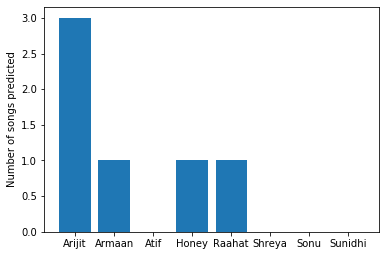

Actual Singer: Armaan Malik


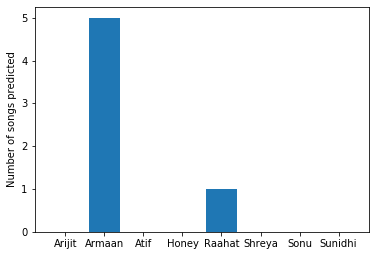

Actual Singer: Atif Aslam


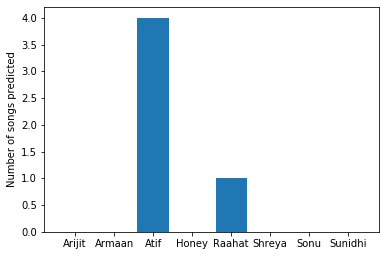

Actual Singer: Honey Singh


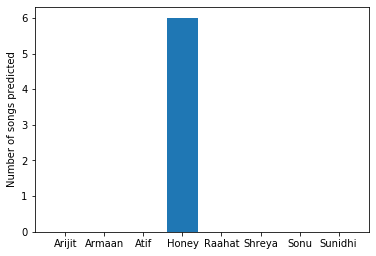

Actual Singer: Raahat Fateh Ali Khan


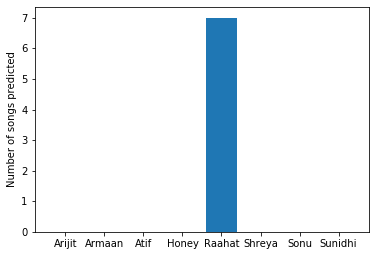

Actual Singer: Shreya Ghoshal


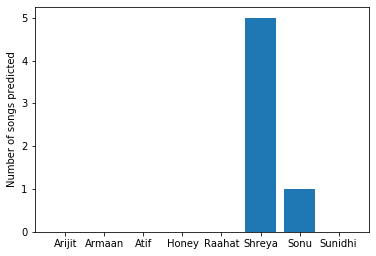

Actual Singer: Sonu Nigam


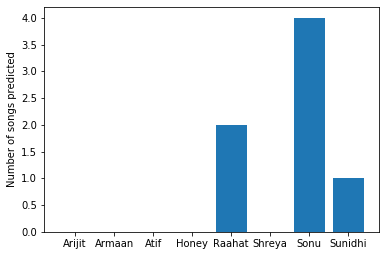

Actual Singer: Sunidhi Chauhan


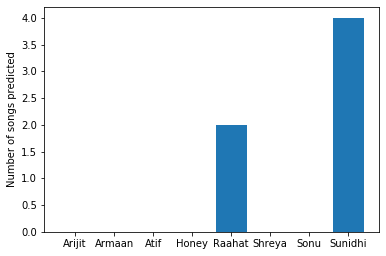

In [74]:
for singer in all_singers.keys():
  fig, ax = plt.subplots()
  fig.subplots_adjust(bottom=0.1)
  ax.set_xticklabels([i.split()[0] for i in list(singer_labels.values())]) 
  plt.bar(all_singers[singer].keys(), all_singers[singer].values())
  print('Actual Singer:', singer)
  plt.ylabel('Number of songs predicted')
  plt.show()
